<h3>Analisis algoritma Machine Learning menggunakan Suport Vektor Machine, Naive Bayes, dan Random Forest untuk menemukan akurasi tinggi dalam penerimaa Vaksin H1N1 kasus Influenza</h3>
<p>Dalam kasus ini penulis memiliki batasan dalam melakukan kasusnya, yang hanya berfokus pada prediksi vaksin H1N1 bukan vaksin flu musiaman atau (seasonal_vaksin)</p>
<p>Tujuanya adalah untuk memberikan analisa mana model machine learning yang terbaik dalam akurasi penerimaan vaksin</p>

In [119]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Data Understanding</h2>

In [120]:
data = pd.read_csv('data/H1N1_Flu_Vaccines.csv')
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [121]:
#cek dimensi data dan tipe data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [122]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
respondent_id,26707.0,13353.000000,7709.791156,0.0,6676.5,13353.0,20029.5,26706.0
h1n1_concern,26615.0,1.618486,0.910311,0.0,1.0,2.0,2.0,3.0
h1n1_knowledge,26591.0,1.262532,0.618149,0.0,1.0,1.0,2.0,2.0
behavioral_antiviral_meds,26636.0,0.048844,0.215545,0.0,0.0,0.0,0.0,1.0
behavioral_avoidance,26499.0,0.725612,0.446214,0.0,0.0,1.0,1.0,1.0
behavioral_face_mask,26688.0,0.068982,0.253429,0.0,0.0,0.0,0.0,1.0
behavioral_wash_hands,26665.0,0.825614,0.379448,0.0,1.0,1.0,1.0,1.0
behavioral_large_gatherings,26620.0,0.358640,0.479610,0.0,0.0,0.0,1.0,1.0
behavioral_outside_home,26625.0,0.337315,0.472802,0.0,0.0,0.0,1.0,1.0
behavioral_touch_face,26579.0,0.677264,0.467531,0.0,0.0,1.0,1.0,1.0


In [123]:
#cek duplikasi data

data.duplicated().sum()

0

In [124]:
#cek data hilang

data.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

C:\Users\asus\AppData\Local\Temp\ipykernel_28368\4184389366.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="h1n1_concern",data=data, palette="pastel")


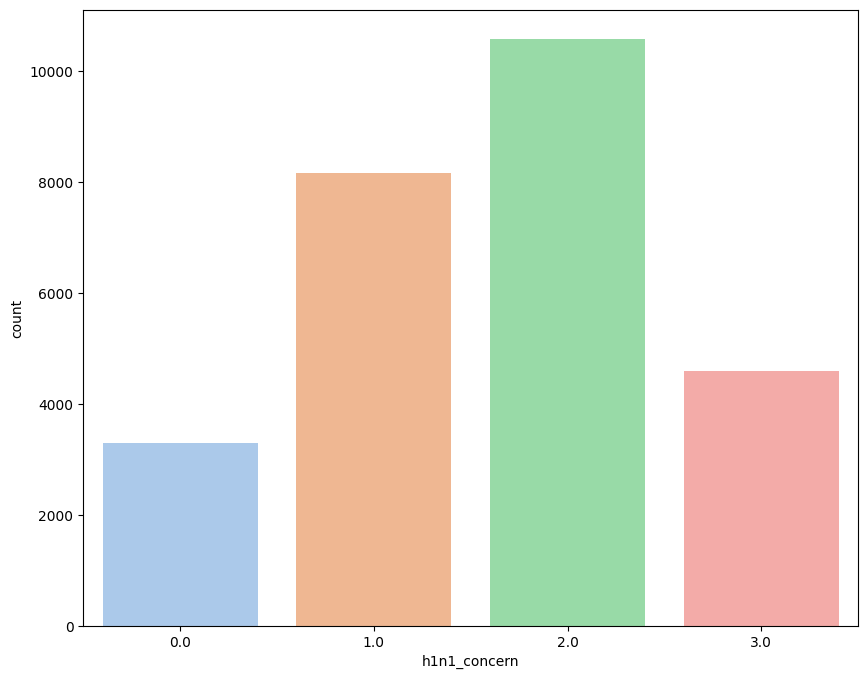

In [153]:
plt.figure(figsize=(10,8))
sns.countplot(x="h1n1_concern",data=data, palette="pastel")
plt.show()

In [125]:
data['age_group'] = data['age_group'].str.split().str[0]

In [126]:
data.drop(columns=["respondent_id","health_insurance","doctor_recc_seasonal","opinion_seas_vacc_effective","opinion_seas_risk","opinion_seas_sick_from_vacc","race","race","hhs_geo_region","employment_industry","employment_occupation", "seasonal_vaccine"], inplace=True)

In [127]:
# display(data.head())
# data.shape


In [128]:
#memisahkan object dan numerical
object_columns = data.select_dtypes(include=['object'])
numerical_columns = data.select_dtypes(include=['int64','float64'])

In [129]:
display(numerical_columns.head())
object_columns.head(10)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,chronic_med_condition,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,household_adults,household_children,h1n1_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,4.0,4.0,0.0,0.0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,3.0,1.0,1.0,2.0,0.0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,1.0,0.0,0


,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa
0,55,< 12 Years,Female,Below Poverty,Not Married,Own,Not in Labor Force,Non-MSA
1,35,12 Years,Male,Below Poverty,Not Married,Rent,Employed,"MSA, Not Principle City"
2,18,College Graduate,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,"MSA, Not Principle City"
3,65+,12 Years,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Principle City"
4,45,Some College,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City"
5,65+,12 Years,Male,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Principle City"
6,55,< 12 Years,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,"MSA, Not Principle City"
7,45,Some College,Female,"<= $75,000, Above Poverty",Married,Own,Employed,Non-MSA
8,45,College Graduate,Male,"> $75,000",Married,Own,Employed,"MSA, Not Principle City"
9,55,12 Years,Male,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,"MSA, Not Principle City"


In [130]:
#mengisi data hilang pada kolom numerik dengan mean

numerical_columns.fillna(numerical_columns.mode().iloc[0], inplace=True)

In [131]:
#mengisi data hilang pada kolom object dengan modus

object_columns.fillna(object_columns.mode().iloc[0], inplace=True)

In [132]:
print("Missing value numerik:")
print(numerical_columns.isnull().sum().sum())

print("Missing value kategorikal:")
print(object_columns.isnull().sum().sum())


Missing value numerik:
0
Missing value kategorikal:
0


In [133]:
print(numerical_columns.isnull().sum())
print(object_columns.isnull().sum())


h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
household_adults               0
household_children             0
h1n1_vaccine                   0
dtype: int64
age_group            0
education            0
sex                  0
income_poverty       0
marital_status       0
rent_or_own          0
employment_status    0
census_msa           0
dtype: int64


In [134]:
data_cleaned = pd.concat([numerical_columns, object_columns], axis=1)

C:\Users\asus\AppData\Local\Temp\ipykernel_28368\2768626048.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


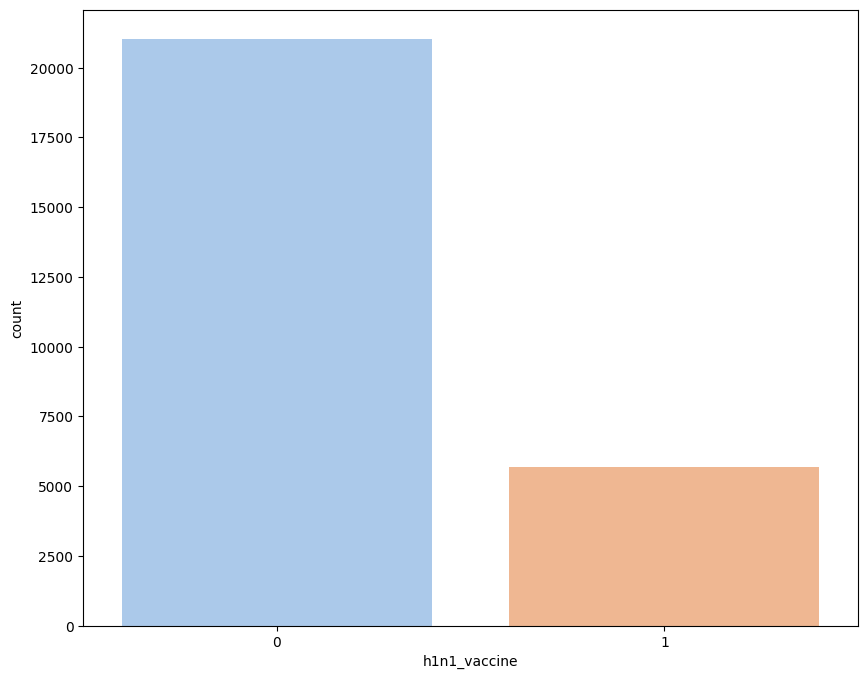

In [148]:
plt.figure(figsize=(10,8))
sns.countplot(
    x="h1n1_vaccine",
    data=data_cleaned,
    palette="pastel"
)

plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_28368\1386350296.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="h1n1_concern",data=data_cleaned, palette="pastel")


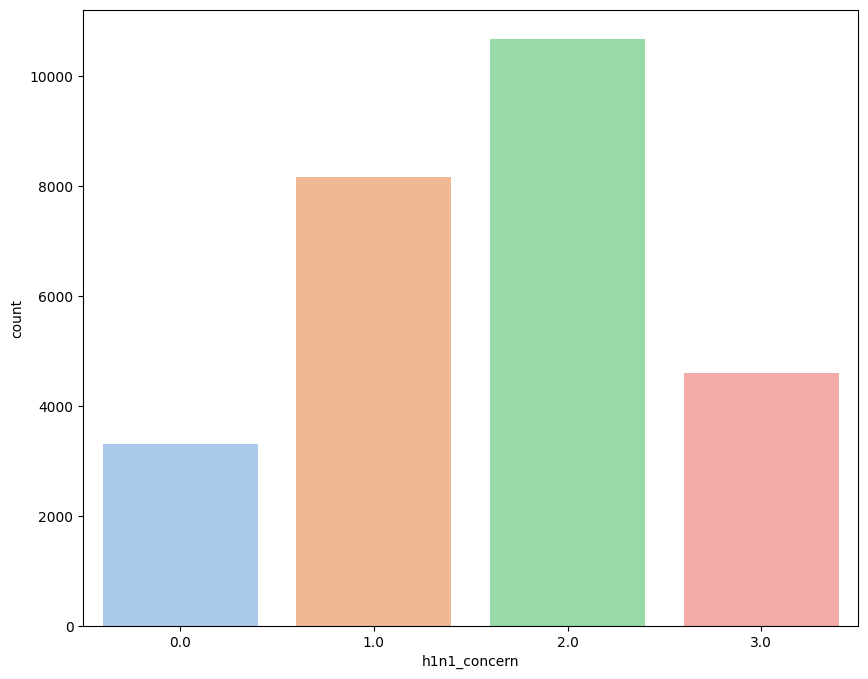

In [152]:
plt.figure(figsize=(10,8))
sns.countplot(x="h1n1_concern",data=data_cleaned, palette="pastel")
plt.show()